In [1]:
%matplotlib inline

## Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:, survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

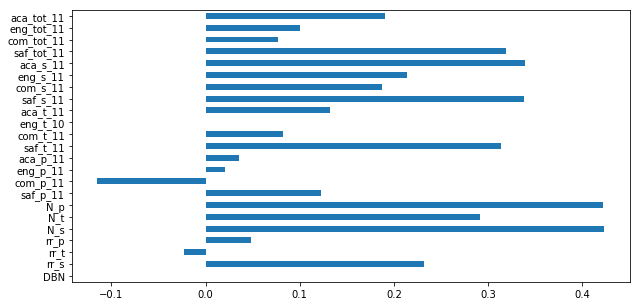

In [11]:
survey_correlathions = correlations[survey_fields]
survey_correlathions.plot(kind="barh", figsize=(10, 5))

Findings
====
Most statisticians like to see correlations beyond at least **+.5** or **–.5** before getting too excited about them, but in our case correlation values above **.25** or below **-.25** are enough to qualify a correlation as interesting. We can see that many field correlations, to a greater extent, are not interesting for analysis. We may divide takes data by some analysis group:
* **"0. Without linear relations"**, which are of absolutely no interest us. 
* The greater half tends to the **"+.3 A weak uphill (positive) linear relationship"**, that also not interested in analysis.
* Near to **"+.3 _A weak uphill (positive) linear relationship"** and **"+.5 A moderate uphill (positive) relationship"** there are some intresting cases.
   - There are correlations between `N_s`, `N_t`, `N_p`, and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.
   - It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.
   - How students and teachers perceived safety (`saf_t_11` and `saf_s_11`) correlate with sat_score. This makes sense, as it's hard to teach or learn in an unsafe environment.
   - The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards or `aca_p_11`, how parents perceive academic standards.

## Exploring safety and SAT scores

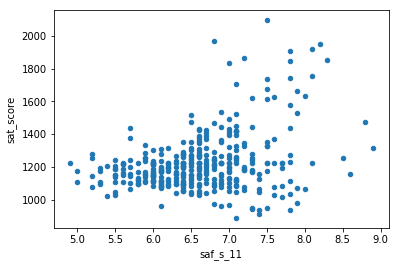

In [12]:
combined.plot.scatter("saf_s_11","sat_score")

Findings
=====
We may say, that there is a safety at school are correlated with SAT scores. Ironically, there are several schools that give data on SAT results above 1600, although SAT does not exceed 1600. In addition, there are several schools with a security level below the average with correspondingly lower SAT ratings, but despite this, a large half of schools with a low safety rating are kept at the SAT rating between 1000 and 1400.

## Plotting safety

/Users/isfilimonov/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/isfilimonov/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


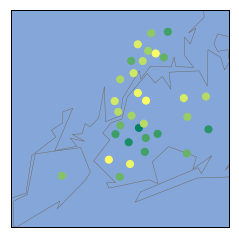

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
#m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Findings
=====
It seems that Upper Manhattan and parts of Queens and the Bronx have lower safety rates, while Brooklyn has high safety ratings.

## Exploring race and SAT scores

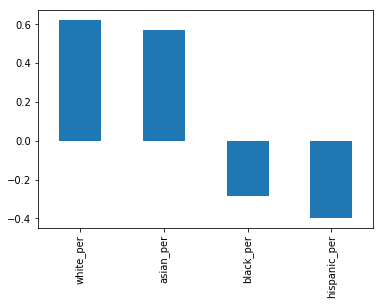

In [14]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
race_correlathions = correlations[race_fields]
race_correlathions.plot(kind="bar")

It seems that the correlation of white and Asian students has a low positive correlation with SAT estimates, otherwise, the percentage of blacks and Hispanic students in schools has low negative correlation ratings with SAT ratings.

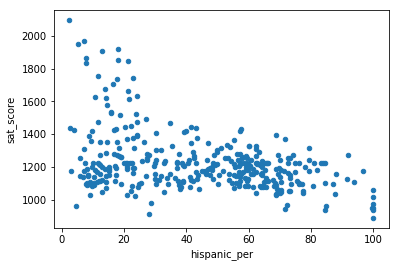

In [15]:
combined.plot("hispanic_per", "sat_score", kind="scatter")

Interesting clusters of data:
* At 10% and above 1600
* In the neighborhood of 100%

In [16]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are mainly targeted at recent immigrants in the United States. There are many students in these schools who are studying English, which explains the lower ratings of SAT.

In [17]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the above schools appear to be specialized scientific and technological schools that receive additional funding, and only accept students who take the entrance exam. This does not explain the low level of hispanic_per, but he explains why their students are trying to do better on SAT - these are students from all over New York who have coped well with a standardized test.

## Exploring gender and SAT stores

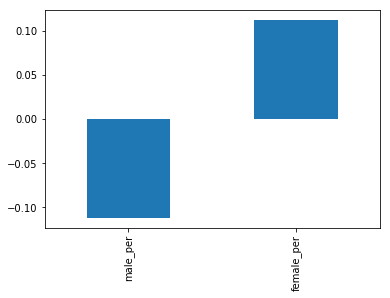

In [18]:
gender_fields = ["male_per", "female_per"]
gender_correlathions = correlations[gender_fields]
gender_correlathions.plot(kind="bar")

We see that a high percentage of women in the school positively correlate with the SAT score, while a high percentage of men in the school negatively correlate with the SAT score, but no correlation is extremely strong.

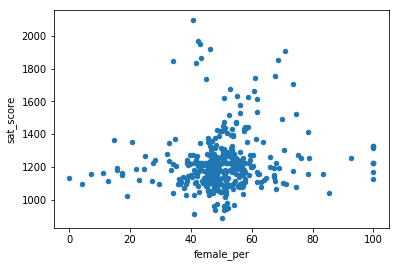

In [19]:
combined.plot("female_per", "sat_score", kind="scatter")

Based on the scattering diagram, there seems to be no real correlation between sat_score and female_per. Nevertheless, there is a group of schools with a high percentage of women (from 60 to 80) and high rates of SAT.

In [20]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to represent very selective schools of the humanities with high academic standards.

## Exploring AP scores with SAT scores

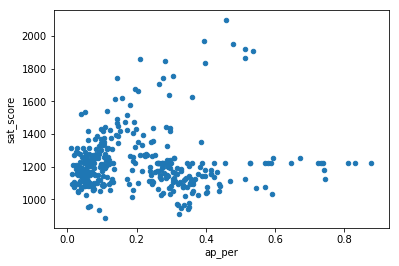

In [21]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot(x='ap_per', y='sat_score', kind="scatter")

It seems that there is a correlation between the percentage of students in the school who take the AP exam and their average SAT scores. However, this is not a very strong correlation.